In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from matplotlib.gridspec import GridSpec

plt.style.use(['science', 'grid'])

In [5]:
envs = ['Acrobot-v1', 'CartPole-v1', 'Pendulum-v1', 'LunarLander-v2', 'BipedalWalker-v3']

In [6]:
def get_log(folder_name, key):
    """Get the logging information

    Parameters
    ----------
    folder_name : str
        The folder that contains csv files of trained models
    key : str
        The attribute to extract from the csv files

    Returns
    -------
    timesteps : np.ndarray
        The timesteps of the training
    info : np.ndarray
        The attribute of the training
    """
    timesteps, info = [], []

    for name in os.listdir(folder_name):
        if name.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder_name, name))
            timesteps.append(df['timesteps'].values)
            info.append(df[key].values)

    min_length = min([len(t) for t in timesteps])
    timesteps = [t[:min_length] for t in timesteps]
    info = [r[:min_length] for r in info]

    timesteps = np.array(timesteps)
    info = np.array(info)

    return timesteps, info

### The making of Table 1 in the paper

In [7]:
# Collect and process returns
ppo_returns = []
de_ppo_returns = []
for env in envs:
    ppo_returns.append(get_log(f'saved/logs/{env}/ppo', 'return')[1][:, -50:])
    de_ppo_returns.append(
        get_log(f'saved/logs/{env}/de-ppo', 'return')[1][:, -50:])

# Convert to numpy arrays
ppo_returns = np.array(ppo_returns)
de_ppo_returns = np.array(de_ppo_returns)

# Compute mean and std across seeds and iterations
ppo_mean_final = ppo_returns.mean(axis=(1, 2))
ppo_std_final = ppo_returns.std(axis=(1, 2))
de_ppo_mean_final = de_ppo_returns.mean(axis=(1, 2))
de_ppo_std_final = de_ppo_returns.std(axis=(1, 2))

# Create the DataFrame
results = pd.DataFrame({
    'task': envs,
    'ppo': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(ppo_mean_final, ppo_std_final)],
    'de-ppo': [f"{mean:.2f} ± {std:.2f}" for mean, std in zip(de_ppo_mean_final, de_ppo_std_final)]
})

# Display and save the results
results
# results.to_csv('evaluation_results.csv', index=False)

,task,ppo,de-ppo
0,Acrobot-v1,-82.34 ± 11.47,-81.88 ± 11.95
1,CartPole-v1,481.05 ± 44.74,496.37 ± 23.63
2,Pendulum-v1,-168.08 ± 42.76,-152.09 ± 28.67
3,LunarLander-v2,213.43 ± 51.68,217.77 ± 37.85
4,BipedalWalker-v3,163.16 ± 53.36,169.05 ± 59.44


### The making of Figure 2 in the paper

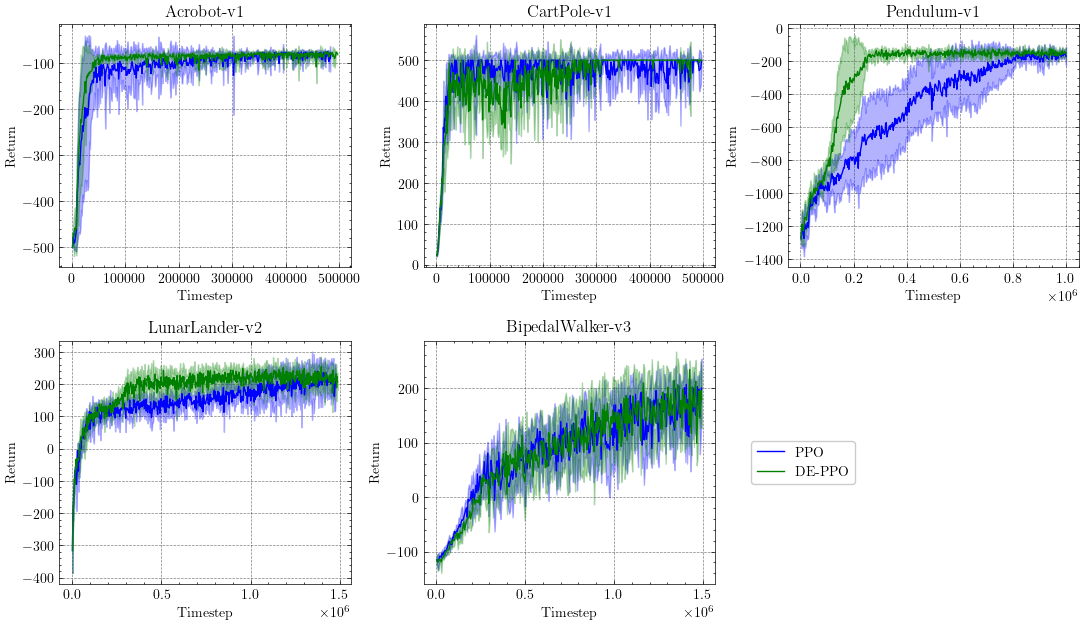

In [ ]:
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(2, 3, figure=fig, wspace=0.25, hspace=0.3)

# Create the subplots
axes = []
for i in range(5):
    row, col = divmod(i, 3)
    axes.append(fig.add_subplot(gs[row, col]))

for i, env in enumerate(envs):
    ax = axes[i]
    # Get returns of PPO and DE-PPO
    ppo_timesteps, ppo_returns = get_log(f'saved/logs/{env}/ppo', 'return')
    de_ppo_timesteps, de_ppo_returns = get_log(f'saved/logs/{env}/de-ppo', 'return')

    # Plot the mean and std of the returns of PPO
    ax.plot(ppo_timesteps.mean(axis=0), ppo_returns.mean(axis=0), label='PPO', color='blue')
    ax.fill_between(ppo_timesteps.mean(axis=0),
                    ppo_returns.mean(axis=0) - ppo_returns.std(axis=0),
                    ppo_returns.mean(axis=0) + ppo_returns.std(axis=0),
                    alpha=0.3, color='blue')

    # Plot the mean and std of the returns of DE-PPO
    ax.plot(de_ppo_timesteps.mean(axis=0), de_ppo_returns.mean(axis=0), label='DE-PPO', color='g')
    ax.fill_between(de_ppo_timesteps.mean(axis=0),
                    de_ppo_returns.mean(axis=0) - de_ppo_returns.std(axis=0),
                    de_ppo_returns.mean(axis=0) + de_ppo_returns.std(axis=0),
                    alpha=0.3, color='g')

    ax.set_title(env)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Return')
    if i == len(envs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))

fig.add_subplot(gs[1, 2]).set_visible(False)
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)
plt.show()